## Referências
- [1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [3] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [4] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

Contém a forma como chegamos nos dados para a visualização de chutes ao gol e também versões iniciais da visualização.

In [1]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
import matplotsoccer as mps
warnings.filterwarnings("ignore")

In [5]:
# carregando os eventos
country_name = "Spain"

path: str = f"../data/wyscout/events/events_{country_name}.json"
events: pd.DataFrame = pd.read_json(path_or_buf=path)

In [6]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

In [9]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
path: str = f"../data/wyscout/matches/matches_{country_name}.json"
matches: pd.DataFrame = pd.read_json(path_or_buf=path)

In [10]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches: list = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, "teamsData"]).T
    match["matchId"] = matches.loc[i, "wyId"]
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 380/380 [00:00<00:00, 2752.01it/s]


In [11]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
spadl: list = []
game_ids: list = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
    match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
    match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [02:13<00:00,  2.84it/s]


In [12]:
path: str = "../data/wyscout/players/players.json"
players: pd.DataFrame = pd.read_json(path_or_buf=path)
players["player_name"] = players["shortName"].str.decode("unicode-escape")
players = players[["wyId", "player_name"]].rename(columns={"wyId": "player_id"})
spadl = spadl.merge(players, on="player_id", how="left")
spadl.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Trigueros
1,2565548,1,3.137020,682,274435,52.50,34.00,47.25,47.60,180864418,0,0,1,1,pass,success,foot,E. Ünal
2,2565548,1,6.709668,682,364860,47.25,47.60,39.90,59.84,180864420,0,0,1,2,pass,success,foot,Rodri
3,2565548,1,8.805497,682,3534,39.90,59.84,33.60,21.08,180864421,0,0,1,3,pass,success,foot,Jaume Costa
4,2565548,1,14.047492,682,3695,33.60,21.08,32.55,42.84,180864422,0,0,1,4,pass,success,foot,Álvaro González


Criando um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.

In [13]:
# Definindo dimensões do campo para o plot
GOAL_CENTER_X: int = 105
GOAL_CENTER_Y: int = 34

UPPER_CROSSBAR_X: int = 105
UPPER_CROSSBAR_Y: int = 38

LOWER_CROSSBAR_X: int = 105
LOWER_CROSSBAR_Y: int = 30

Definindo as features que serão utilizados no modelo de Regressão logística para prever a probabilidade de um chute ser gol.

In [14]:
shots: pd.DataFrame = spadl.query('type_name in ("shot", "shot_freekick")').copy()

shots["distance_to_goal"] = np.sqrt((shots["start_x"] - GOAL_CENTER_X) ** 2 + (shots["start_y"] - GOAL_CENTER_Y) ** 2)

def get_shot_angle(shot_pos_x: np.float_, shot_pos_y: np.float_) -> np.float_:
    v1: np.array = np.array([UPPER_CROSSBAR_X - shot_pos_x, UPPER_CROSSBAR_Y - shot_pos_y])
    v2: np.array = np.array([LOWER_CROSSBAR_X - shot_pos_x, LOWER_CROSSBAR_Y - shot_pos_y])
    return np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
    
shots["angle_of_shot"] = shots[["start_x", "start_y"]].apply(lambda pos: get_shot_angle(pos["start_x"], pos["start_y"]), axis=1)
shots["squared_distance_to_goal"] = shots["distance_to_goal"] ** 2
shots["bodypart_capacity_of_scoring"] = shots["bodypart_name"].apply(lambda x: 1 if x == "foot" else .125)
shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,result_id,action_id,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_of_shot,squared_distance_to_goal,bodypart_capacity_of_scoring
20,2565548,1,57.771186,695,225089,97.65,44.88,105.0,34.00,180865315,...,0,20,shot,fail,foot_left,José Luis Morales,13.130000,0.359618,172.3969,0.125
22,2565548,1,60.727239,695,255738,84.00,27.88,84.0,27.88,180864547,...,0,22,shot,fail,foot_right,J. Lerma,21.873601,0.348455,478.4544,0.125
93,2565548,1,446.986112,682,37831,92.40,29.24,92.4,29.24,180864486,...,0,93,shot,fail,foot_right,C. Bacca,13.469135,0.547278,181.4176,0.125
96,2565548,1,488.929113,682,15214,91.35,23.12,105.0,27.20,180864491,...,0,96,shot,fail,foot_right,A. Rukavina,17.455569,0.361618,304.6969,0.125
180,2565548,1,948.872079,695,225089,78.75,40.80,105.0,34.00,180864792,...,0,180,shot,fail,foot_right,José Luis Morales,27.116462,0.284055,735.3025,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.5,46.24,253302329,...,0,1264,shot,fail,foot_right,R. Martínez,16.126612,0.331469,260.0676,0.125
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.0,37.40,253302547,...,1,1396,shot,success,foot_left,Samu Castillejo,18.962067,0.193160,359.5600,0.125
474656,2565927,2,2672.823612,682,134174,96.60,11.56,96.6,11.56,253302585,...,0,1418,shot_freekick,fail,foot_left,Samu Castillejo,23.960668,0.119829,574.1136,0.125
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.0,30.60,253302642,...,0,1441,shot,fail,foot_right,K. Benzema,23.284544,0.279820,542.1700,0.125


- Distância até o gol: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição do gol como sendo as coordenadas (105, 34), exatamente ao centro do gol. A distância entre a bola e o gol no momento do chute é uma das *features* mais óbvias a se pensar quando o assunto 'um modelo de *expected goals*. De maneira simples podemos analisar e notar que chutes de longas distância, de uma forma geral, possuem uma menor probabilidade de resultarem em gol, assim como é análogo o caso de chutes a curta distância.

- Ângulo de chute: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição das traves do gol como sendo as coordenadas (105, 38) para a trave "de cima" e (105, 30) para a trave "de baixo". Dessa forma, considera-se que o ângulo de chute é o ângulo entre os vetores formados por esses três pontos, onde a  posição da bola seria o ponto de origem. Assim como a distância entre a bola e o gol, o ângulo de chute também é uma das *features* mais óbvias a se pensar ao considerar um modelo de *expected goals*. Chutes que "enxergam" uma grande área do gol comumente possuem maior probabilidade de resultarem em gol, enquanto chutes em posições muito extremas, que significam um baixo ângulo de visão do gol, resultam raramente em sucesso.

- Distância quadrado até o gol: essa *feature* é simplesmente a primeira *feature* de distância do chute até o gol, mas adicionada como um termo quadrático e não linear. Isso é feito para que a distância de chute até o gol tenha um impacto maior na qualidade das predições, aumentando principalmente a qualidade das predições de chutes que estejam a uma cureta distância do gol (algo em torno de 6 metros ou menos). Tal *feature* é mais bem discutida e detalhada no seguinte artigo: https://towardsdatascience.com/modeling-expected-goals-a756baa2e1db.

- Capacidade de parte do corpo em marcar gols: por fim, considera-se a quarta *feature* do modelo como sendo a parte do corpo com a qual o chute foi realizado. Após uma análise rápida dos dados de entrada, nota-se que chutes com o pé são aproximadamente 8 vezes mais frequentes do que chutes com outras partes do corpo, e essa proporção se mantém para o subconjunto de chutes que resultam em sucesso. Dessa forma, foi atribuido um valor de 1 para essa *feature* quando os chutes foram feitos com o pé, e 0.125 caso contrário.

Criando e treinando o modelo.

In [15]:
shots["goal"] = shots["result_name"].apply(lambda res: int(res == "success"))
shots.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal", "bodypart_capacity_of_scoring"]].to_numpy(), shots["goal"].to_numpy(), test_size=0.3, random_state=0)
clf = LogisticRegression(random_state=0, max_iter=1_000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Acurácia para conjunto de treino: {clf.score(X_train, y_train)}")
print(f"Acurácia para conjunto de teste: {clf.score(X_test, y_test)}")

Acurácia para conjunto de treino: 0.895441450601593
Acurácia para conjunto de teste: 0.8972332015810277


Usando o modelo treinadopara prever a probabilidade de gol de todos os chutes do dataframe "shots", essa probabilidade foi colocada na nova coluna: "xG".

In [16]:
shots["xG"] = shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal", "bodypart_capacity_of_scoring"]].apply(lambda x: clf.predict_proba([[x["distance_to_goal"], x["angle_of_shot"], x["squared_distance_to_goal"], x["bodypart_capacity_of_scoring"]]])[0][1], axis=1)
xG_goal_sum: pd.DataFrame = shots.groupby(by="player_name")[["goal", "xG"]].sum().copy()
xG_goal_sum["goal_xG_diff"] = xG_goal_sum["goal"] - xG_goal_sum["xG"]
xG_goal_sum.head()

,goal,xG,goal_xG_diff
player_name,,,
A. Aquilani,0,0.852290,-0.852290
A. Arribas,0,0.138958,-0.138958
A. Fernández,0,0.026878,-0.026878
A. Griezmann,17,7.465349,9.534651
A. Guardado,1,1.805826,-0.805826


In [17]:
shots["xG"] = shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal", "bodypart_capacity_of_scoring"]].apply(lambda x: clf.predict_proba([[x["distance_to_goal"], x["angle_of_shot"], x["squared_distance_to_goal"], x["bodypart_capacity_of_scoring"]]])[0][1], axis=1)
player_name = "Cristiano Ronaldo"
filtered_shots = shots[
    (shots["player_name"] == player_name) & 
    ((shots["xG"] < 0.3) & (shots["result_name"] == "success"))].sort_values(by="xG").head(5)
filtered_shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_of_shot,squared_distance_to_goal,bodypart_capacity_of_scoring,goal,xG
289488,2565780,2,1192.623899,675,3322,94.50,46.24,105.0,34.0,229136767,...,shot,success,foot_right,Cristiano Ronaldo,16.126612,0.331469,260.0676,0.125,1,0.083555
182801,2565695,1,1331.988046,675,3322,92.40,25.84,105.0,30.6,213089211,...,shot,success,foot_right,Cristiano Ronaldo,15.011516,0.448739,225.3456,0.125,1,0.107268
329247,2565812,1,2703.844052,675,3322,90.30,32.64,105.0,37.4,232024410,...,shot,success,foot_left,Cristiano Ronaldo,14.762778,0.527342,217.9396,0.125,1,0.122301
336865,2565818,1,1981.653014,675,3322,92.40,39.44,105.0,37.4,233365613,...,shot,success,foot_right,Cristiano Ronaldo,13.724198,0.529201,188.3536,0.125,1,0.130821
358742,2565836,1,626.836376,675,3322,91.35,36.72,105.0,30.6,235353184,...,shot,success,foot_left,Cristiano Ronaldo,13.918366,0.550974,193.7209,0.125,1,0.133383


Testando o plot dos 5 chutes feitos pelo jogador Cristiano Ronaldo e que haviam as menores probabilidades em nosso modelo. No caso, usamos duas bibliotecas para ver qual seria a melhor pra nossa visualização.

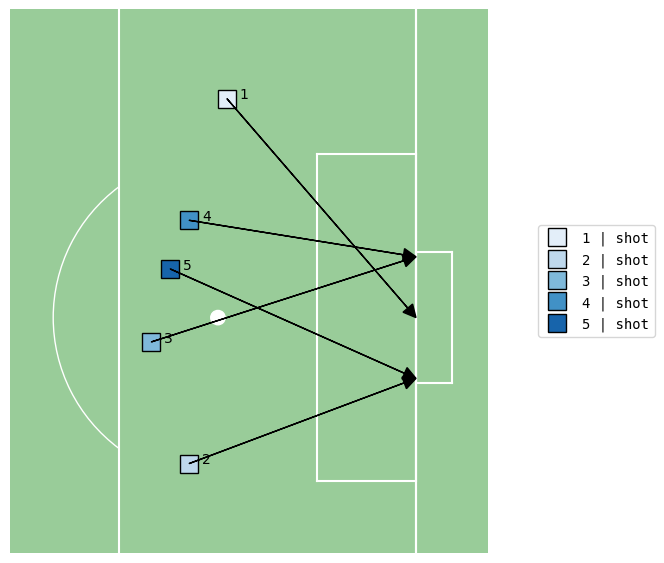

In [18]:
mps.actions(
    location=filtered_shots[["start_x", "start_y", "end_x", "end_y"]],
    action_type=filtered_shots.type_name,
    result=filtered_shots.result_name == "success",
    zoom=True,
    color="green",
)

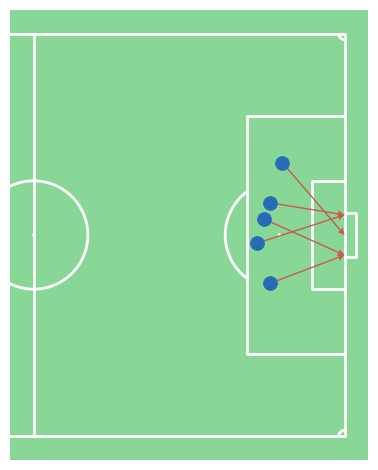

In [19]:
plt.style.use("ggplot")

pitch = Pitch(
                pitch_type="custom", 
                pitch_color="#88d797",
                corner_arcs=True,
                half=True,
                goal_type="box",
                pitch_length=105,
                pitch_width=68,
            )

fig, ax = pitch.draw()

for idx, shot in filtered_shots.iterrows():
    pitch.scatter(shot['start_x'], shot['start_y'], color='#276cb7', s=100, ax=ax, label='Shooter', zorder=1.2)
    pitch.arrows(shot['start_x'], shot['start_y'], shot['end_x'], shot['end_y'], label='shot', color='#cb5a4c', width=1, headwidth=5, headlength=5, ax=ax)